### Import libraries and declare dependencies 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.optim.optimizer import Optimizer, required

import matplotlib.pyplot as plt
import numpy as np
import math

import tqdm as tqdm

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")

Device: mps


In [3]:
torch.manual_seed(22)

### Dataset and EDA

In [4]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(trainset))

# Create indices for the split
indices = list(range(len(trainset)))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create subset data loaders
train_data = Subset(trainset, train_indices)
val_data = Subset(trainset, val_indices)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
valloader = DataLoader(val_data, batch_size=128, shuffle=False)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

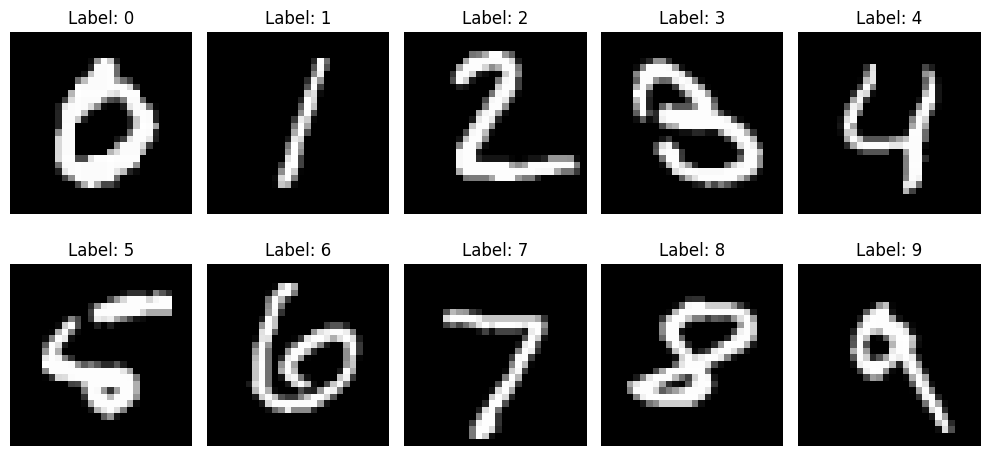

In [5]:
label_images = {}

for i in range(len(testset)):
    image, label = testset[i]
    if label not in label_images:
        label_images[label] = image
        if len(label_images) == 10:
            break

plt.figure(figsize=(10, 5))
for label, image in label_images.items():
    plt.subplot(2, 5, label + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show();

### Define Custom Optimizers

In [27]:
# NAG Optimizer
class NAG(Optimizer):
    def __init__(self, params, lr=required, momentum=0, weight_decay=0):
        defaults = dict(lr=lr, lr_old=lr, momentum=momentum, weight_decay=weight_decay)
        super(NAG, self).__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self):
        return True

    @property
    def supports_flat_params(self):
        return True

    def step(self, closure=None):
        """Performs a single optimization step.

        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            lr = group["lr"]
            lr_old = group.get("lr_old", lr)
            lr_correct = lr / lr_old if lr_old > 0 else lr

            for p in group["params"]:
                if p.grad is None:
                    continue

                p_data_fp32 = p.data
                if p_data_fp32.dtype in {torch.float16, torch.bfloat16}:
                    p_data_fp32 = p_data_fp32.float()

                d_p = p.grad.data.float()
                param_state = self.state[p]
                if "momentum_buffer" not in param_state:
                    param_state["momentum_buffer"] = torch.zeros_like(d_p)
                else:
                    param_state["momentum_buffer"] = param_state["momentum_buffer"].to(
                        d_p
                    )

                buf = param_state["momentum_buffer"]

                if weight_decay != 0:
                    p_data_fp32.mul_(1 - lr * weight_decay)
                p_data_fp32.add_(buf, alpha=momentum * momentum * lr_correct)
                p_data_fp32.add_(d_p, alpha=-(1 + momentum) * lr)

                buf.mul_(momentum * lr_correct).add_(d_p, alpha=-lr)

                if p.data.dtype in {torch.float16, torch.bfloat16}:
                    p.data.copy_(p_data_fp32)

            group["lr_old"] = lr

        return loss

In [11]:
# ProxSG
class ProxSG(Optimizer):
    def __init__(self, params, lr=required, lambda_=required):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        if lambda_ is not required and lambda_ < 0.0:
            raise ValueError("Invalid lambda: {}".format(lambda_))

        defaults = dict(lr=lr, lambda_=lambda_)
        super(ProxSG, self).__init__(params, defaults)

    def calculate_d(self, x, grad_f, lambda_, lr):
        '''
            Calculate d for Omega(x) = ||x||_1
        '''
        trial_x = torch.zeros_like(x)
        pos_shrink = x - lr * grad_f - lr * \
            lambda_  # new x is larger than lr * lambda_
        neg_shrink = x - lr * grad_f + lr * \
            lambda_  # new x is less than -lr * lambda_
        pos_shrink_idx = (pos_shrink > 0)
        neg_shrink_idx = (neg_shrink < 0)
        trial_x[pos_shrink_idx] = pos_shrink[pos_shrink_idx]
        trial_x[neg_shrink_idx] = neg_shrink[neg_shrink_idx]
        d = trial_x - x

        return d

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad_f = p.grad.data

                if len(p.shape) > 1:  # weights
                    s = self.calculate_d(
                        p.data, grad_f, group['lambda_'], group['lr'])
                    p.data.add_(s, alpha=1)
                else:  # bias
                    p.data.add_(grad_f, alpha=-group['lr'])
        return loss

In [12]:
# SVRG Optimizer
class SVRG(Optimizer):
    r""" implement SVRG """ 

    def __init__(self, params, lr=required, freq =10):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, freq=freq)
        self.counter = 0
        self.counter2 = 0
        self.flag = False
        super(SVRG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SVRG, self).__setstate__(state)
        # for group in self.param_groups:
        #     group.setdefault('m', )

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            freq = group['freq']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                param_state = self.state[p]
                
                if 'large_batch' not in param_state:
                    buf = param_state['large_batch'] = torch.zeros_like(p.data)
                    buf.add_(d_p) #add first large, low variance batch
                    #need to add the second term in the step equation; the gradient for the original step!
                    buf2 = param_state['small_batch'] = torch.zeros_like(p.data)

                buf = param_state['large_batch']
                buf2 = param_state['small_batch']

                if self.counter == freq:
                    buf.data = d_p.clone() #copy new large batch. Begining of new inner loop
                    temp = torch.zeros_like(p.data)
                    buf2.data = temp.clone()
                    
                if self.counter2 == 1:
                    buf2.data.add_(d_p) #first small batch gradient for inner loop!

                #dont update parameters when computing large batch (low variance gradients)
                if self.counter != freq and self.flag != False:
                    p.data.add_((d_p - buf2 + buf), alpha=-group['lr'])

        self.flag = True #rough way of not updating the weights the FIRST time we calculate the large batch gradient
        
        if self.counter == freq:
            self.counter = 0
            self.counter2 = 0

        self.counter += 1    
        self.counter2 += 1

        return loss

In [14]:
class Prodigy(Optimizer):
    r"""
    Implements Adam with Prodigy step-sizes.
    Leave LR set to 1 unless you encounter instability.
   
    Arguments:
        params (iterable):
            Iterable of parameters to optimize or dicts defining parameter groups.
        lr (float):
            Learning rate adjustment parameter. Increases or decreases the Prodigy learning rate.
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        beta3 (float):
            coefficients for computing the Prodidy stepsize using running averages.
            If set to None, uses the value of square root of beta2 (default: None).
        eps (float):
            Term added to the denominator outside of the root operation to improve numerical stability. (default: 1e-8).
        weight_decay (float):
            Weight decay, i.e. a L2 penalty (default: 0).
        decouple (boolean):
            Use AdamW style decoupled weight decay
        use_bias_correction (boolean):
            Turn on Adam's bias correction. Off by default.
        safeguard_warmup (boolean):
            Remove lr from the denominator of D estimate to avoid issues during warm-up stage. Off by default.
        d0 (float):
            Initial D estimate for D-adaptation (default 1e-6). Rarely needs changing.
        d_coef (float):
            Coefficient in the expression for the estimate of d (default 1.0).
            Values such as 0.5 and 2.0 typically work as well. 
            Changing this parameter is the preferred way to tune the method.
        growth_rate (float):
            prevent the D estimate from growing faster than this multiplicative rate.
            Default is inf, for unrestricted. Values like 1.02 give a kind of learning
            rate warmup effect.
        fsdp_in_use (bool):
            If you're using sharded parameters, this should be set to True. The optimizer
            will attempt to auto-detect this, but if you're using an implementation other
            than PyTorch's builtin version, the auto-detection won't work.
    """
    def __init__(self, params, lr=1.0,
                 betas=(0.9, 0.999), beta3=None,
                 eps=1e-8, weight_decay=0, decouple=True, 
                 use_bias_correction=False, safeguard_warmup=False,
                 d0=1e-6, d_coef=1.0, growth_rate=float('inf'),
                 fsdp_in_use=False):
        if not 0.0 < d0:
            raise ValueError("Invalid d0 value: {}".format(d0))
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 < eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        if decouple and weight_decay > 0:
            print(f"Using decoupled weight decay")

       
        defaults = dict(lr=lr, betas=betas, beta3=beta3,
                        eps=eps, weight_decay=weight_decay,
                        d=d0, d0=d0, d_max=d0,
                        d_numerator=0.0, d_coef=d_coef,
                        k=0, growth_rate=growth_rate,
                        use_bias_correction=use_bias_correction,
                        decouple=decouple, safeguard_warmup=safeguard_warmup,
                        fsdp_in_use=fsdp_in_use)
        self.d0 = d0
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self):
        return False

    @property
    def supports_flat_params(self):
        return True

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        d_denom = 0.0

        group = self.param_groups[0]
        use_bias_correction = group['use_bias_correction']
        beta1, beta2 = group['betas']
        beta3 = group['beta3']
        if beta3 is None:
            beta3 = math.sqrt(beta2)
        k = group['k']

        d = group['d']
        d_max = group['d_max']
        d_coef = group['d_coef']
        lr = max(group['lr'] for group in self.param_groups)

        if use_bias_correction:
            bias_correction = ((1 - beta2**(k+1))**0.5) / (1 - beta1**(k+1))
        else:
            bias_correction = 1

        dlr = d*lr*bias_correction
       
        growth_rate = group['growth_rate']
        decouple = group['decouple']
        fsdp_in_use = group['fsdp_in_use']

        d_numerator = group['d_numerator']
        d_numerator *= beta3

        for group in self.param_groups:
            decay = group['weight_decay']
            k = group['k']
            eps = group['eps']
            group_lr = group['lr']
            d0 = group['d0']
            safeguard_warmup = group['safeguard_warmup']

            if group_lr not in [lr, 0.0]:
                raise RuntimeError(f"Setting different lr values in different parameter groups is only supported for values of 0")

            for p in group['params']:
                if p.grad is None:
                    continue
                if hasattr(p, "_fsdp_flattened"):
                    fsdp_in_use = True
               
                grad = p.grad.data
               
                # Apply weight decay (coupled variant)
                if decay != 0 and not decouple:
                    grad.add_(p.data, alpha=decay)

                state = self.state[p]

                # State initialization
                if 'step' not in state:
                    state['step'] = 0
                    state['s'] = torch.zeros_like(p.data).detach()
                    state['p0'] = p.detach().clone()
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data).detach()
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data).detach()

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
               
                s = state['s']
                p0 = state['p0']

                if group_lr > 0.0:
                    # we use d / d0 instead of just d to avoid getting values that are too small
                    d_numerator += (d / d0) * dlr * torch.dot(grad.flatten(), (p0.data - p.data).flatten()).item()

                    # Adam EMA updates
                    exp_avg.mul_(beta1).add_(grad, alpha=d * (1-beta1))
                    exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=d * d * (1-beta2))

                    if safeguard_warmup:
                        s.mul_(beta3).add_(grad, alpha=((d / d0) * d))
                    else:
                        s.mul_(beta3).add_(grad, alpha=((d / d0) * dlr))
                    d_denom += s.abs().sum().item()

            ######

        d_hat = d

        # if we have not done any progres, return
        # if we have any gradients available, will have d_denom > 0 (unless \|g\|=0)
        if d_denom == 0:
            return loss
       
        if lr > 0.0:
            if fsdp_in_use:
                dist_tensor = torch.zeros(2).cuda()
                dist_tensor[0] = d_numerator
                dist_tensor[1] = d_denom
                dist.all_reduce(dist_tensor, op=dist.ReduceOp.SUM)
                global_d_numerator = dist_tensor[0]
                global_d_denom = dist_tensor[1]
            else:
                global_d_numerator = d_numerator
                global_d_denom = d_denom

            d_hat = d_coef * global_d_numerator / global_d_denom
            if d == group['d0']:
                d = max(d, d_hat)
            d_max = max(d_max, d_hat)
            d = min(d_max, d * growth_rate)

        for group in self.param_groups:
            group['d_numerator'] = global_d_numerator
            group['d_denom'] = global_d_denom
            group['d'] = d
            group['d_max'] = d_max
            group['d_hat'] = d_hat

            decay = group['weight_decay']
            k = group['k']
            eps = group['eps']

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data

                state = self.state[p]

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']

                state['step'] += 1

                denom = exp_avg_sq.sqrt().add_(d * eps)

                # Apply weight decay (decoupled variant)
                if decay != 0 and decouple:
                    p.data.add_(p.data, alpha=-decay * dlr)


                ### Take step
                p.data.addcdiv_(exp_avg, denom, value=-dlr)

            group['k'] = k + 1

        return loss

In [15]:
class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=6, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.use_gc = use_gc

        # level of gradient centralization
        self.gc_gradient_threshold = 3 if gc_conv_only else 1

    def __setstate__(self, state):
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                if grad.dim() > self.gc_gradient_threshold:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(exp_avg, denom, value=-step_size*
                                         group['lr'])

                else:
                    p_data_fp32.add_(exp_avg, alpha=-step_size * group['lr'])

                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

### Convolutional Neural Network

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Train and Test loop

In [7]:
# Define evaluation function
def evaluate(model, type, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        with tqdm.tqdm(total=len(loader), desc='Test', unit='batch') as t:
            for data in loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                t.update(1)

        accuracy = 100 * correct / total
        if type == 1:
            print('Accuracy on test set: %.2f %%' % accuracy)

    return accuracy

In [8]:
def train(model, optimizer, criterion, trainloader, valloader, opt_name, epochs=20):
    model.train()
    losses = []
    best_accuracy = 0.0

    for epoch in range(epochs):
        running_loss = 0.0
        
        with tqdm.tqdm(total=len(trainloader), desc=f'Train Epoch {epoch+1}', unit='batch') as t:
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                t.set_postfix(loss=loss.item())
                t.update(1)

            epoch_loss = running_loss / len(trainloader)
            losses.append(epoch_loss)

            # Evaluate on validation set
            val_accuracy = evaluate(model, 0, valloader)
            print('[Epoch %d] Loss: %.3f, Validation Accuracy: %.2f %%' % (epoch+1, epoch_loss, val_accuracy))

            # Save the model if it has the best accuracy so far
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                torch.save(model.state_dict(), f"best_{opt_name}.pkl")

    return losses

### Train and evaluate the model

In [22]:
# Train and evaluate with different optimizers
optimizers_1 = [optim.SGD, optim.Adam, optim.RMSprop, optim.Adadelta, Ranger]
optimizer_names_1 = ['SGD', 'Adam', 'RMSProp', 'AdaDelta', 'Ranger']

optimizers_2 = [Prodigy, NAG, ProxSG, SVRG]
optimizer_names_2 = ['Prodigy', 'NAG', 'ProxSG', 'SVRG']

In [28]:
train_loss = {}
test_accuracy = {}
convergence_rate = {}

In [29]:
# Part 1
for opt_fn, opt_name in zip(optimizers_1, optimizer_names_1):
    print(f"\nTraining with {opt_name} optimizer:")
    model = CNN().to(device)

    if opt_name == 'ProxSG':
        optimizer = opt_fn(model.parameters(), lr=0.01, lambda_=0.0001)
    else:
        optimizer = opt_fn(model.parameters(), lr=0.01)
    
    criterion = nn.CrossEntropyLoss()
    losses = train(model, optimizer, criterion, trainloader, valloader, opt_name, 10)
    conv_rate = [losses[i] - losses[i-1] for i in range(1, len(losses))]

    # Load the best model for testing
    model.load_state_dict(torch.load(f"best_{opt_name}.pkl"))
    accuracy = evaluate(model, 1, testloader)

    train_loss[opt_name] = losses
    test_accuracy[opt_name] = accuracy
    convergence_rate[opt_name] = conv_rate


Training with SGD optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:33<00:00, 56.62batch/s, loss=0.112]


[Epoch 1] Loss: 0.515, Validation Accuracy: 96.16 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:31<00:00, 60.23batch/s, loss=0.122]


[Epoch 2] Loss: 0.116, Validation Accuracy: 97.43 %


Train Epoch 3: 100%|██████████| 1875/1875 [00:31<00:00, 60.15batch/s, loss=0.135]


[Epoch 3] Loss: 0.080, Validation Accuracy: 98.17 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:31<00:00, 60.18batch/s, loss=0.146]


[Epoch 4] Loss: 0.065, Validation Accuracy: 98.38 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:31<00:00, 60.18batch/s, loss=0.182]


[Epoch 5] Loss: 0.054, Validation Accuracy: 98.81 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:31<00:00, 58.99batch/s, loss=0.00122]


[Epoch 6] Loss: 0.047, Validation Accuracy: 98.97 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:31<00:00, 59.16batch/s, loss=0.00527]


[Epoch 7] Loss: 0.042, Validation Accuracy: 99.02 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:31<00:00, 59.94batch/s, loss=0.00354]


[Epoch 8] Loss: 0.037, Validation Accuracy: 99.17 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:31<00:00, 60.18batch/s, loss=0.000756]


[Epoch 9] Loss: 0.033, Validation Accuracy: 99.15 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:30<00:00, 60.89batch/s, loss=0.00419]


[Epoch 10] Loss: 0.031, Validation Accuracy: 99.33 %


Test: 100%|██████████| 313/313 [00:02<00:00, 116.10batch/s]


Accuracy on test set: 98.89 %

Training with Adam optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:32<00:00, 57.08batch/s, loss=0.189]


[Epoch 1] Loss: 0.355, Validation Accuracy: 94.71 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:32<00:00, 57.17batch/s, loss=0.396]


[Epoch 2] Loss: 0.176, Validation Accuracy: 96.05 %


Train Epoch 3: 100%|██████████| 1875/1875 [00:33<00:00, 56.11batch/s, loss=0.208]


[Epoch 3] Loss: 0.158, Validation Accuracy: 95.47 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:32<00:00, 57.56batch/s, loss=0.458]


[Epoch 4] Loss: 0.151, Validation Accuracy: 95.87 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:32<00:00, 58.54batch/s, loss=0.0287]


[Epoch 5] Loss: 0.150, Validation Accuracy: 96.27 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:32<00:00, 58.16batch/s, loss=0.0149]


[Epoch 6] Loss: 0.136, Validation Accuracy: 96.50 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:31<00:00, 58.79batch/s, loss=0.135]


[Epoch 7] Loss: 0.141, Validation Accuracy: 96.92 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:32<00:00, 58.11batch/s, loss=0.146]


[Epoch 8] Loss: 0.138, Validation Accuracy: 94.93 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:32<00:00, 58.31batch/s, loss=0.164]


[Epoch 9] Loss: 0.132, Validation Accuracy: 96.42 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:32<00:00, 58.08batch/s, loss=0.0967]


[Epoch 10] Loss: 0.134, Validation Accuracy: 95.44 %


Test: 100%|██████████| 313/313 [00:02<00:00, 135.88batch/s]


Accuracy on test set: 96.27 %

Training with RMSProp optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:31<00:00, 59.46batch/s, loss=2.28]


[Epoch 1] Loss: 2.904, Validation Accuracy: 10.60 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:32<00:00, 58.49batch/s, loss=2.29]


[Epoch 2] Loss: 2.302, Validation Accuracy: 10.60 %


Train Epoch 3: 100%|██████████| 1875/1875 [00:31<00:00, 59.31batch/s, loss=2.3]


[Epoch 3] Loss: 2.303, Validation Accuracy: 10.60 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:31<00:00, 58.87batch/s, loss=2.31]


[Epoch 4] Loss: 2.303, Validation Accuracy: 10.60 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:31<00:00, 59.94batch/s, loss=2.31]


[Epoch 5] Loss: 2.303, Validation Accuracy: 10.60 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:31<00:00, 60.20batch/s, loss=2.3]


[Epoch 6] Loss: 2.303, Validation Accuracy: 10.60 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:31<00:00, 59.65batch/s, loss=2.3]


[Epoch 7] Loss: 2.302, Validation Accuracy: 9.95 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:31<00:00, 59.68batch/s, loss=2.28]


[Epoch 8] Loss: 2.302, Validation Accuracy: 10.60 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:31<00:00, 59.12batch/s, loss=2.3]


[Epoch 9] Loss: 2.303, Validation Accuracy: 10.60 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:31<00:00, 59.07batch/s, loss=2.3]


[Epoch 10] Loss: 2.303, Validation Accuracy: 9.98 %


Test: 100%|██████████| 313/313 [00:02<00:00, 134.55batch/s]


Accuracy on test set: 11.35 %

Training with AdaDelta optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:34<00:00, 53.75batch/s, loss=0.36]


[Epoch 1] Loss: 0.778, Validation Accuracy: 92.75 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:34<00:00, 54.84batch/s, loss=0.0995]


[Epoch 2] Loss: 0.229, Validation Accuracy: 94.98 %


Train Epoch 3: 100%|██████████| 1875/1875 [00:34<00:00, 54.71batch/s, loss=0.13]


[Epoch 3] Loss: 0.164, Validation Accuracy: 96.15 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:34<00:00, 54.98batch/s, loss=0.29]


[Epoch 4] Loss: 0.130, Validation Accuracy: 97.08 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:34<00:00, 54.24batch/s, loss=0.214]


[Epoch 5] Loss: 0.109, Validation Accuracy: 97.46 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:33<00:00, 55.15batch/s, loss=0.0792]


[Epoch 6] Loss: 0.095, Validation Accuracy: 97.64 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:34<00:00, 54.87batch/s, loss=0.0578]


[Epoch 7] Loss: 0.085, Validation Accuracy: 97.78 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:34<00:00, 54.91batch/s, loss=0.182]


[Epoch 8] Loss: 0.077, Validation Accuracy: 98.04 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:34<00:00, 54.93batch/s, loss=0.0112]


[Epoch 9] Loss: 0.071, Validation Accuracy: 98.22 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:34<00:00, 54.79batch/s, loss=0.00969]


[Epoch 10] Loss: 0.067, Validation Accuracy: 98.34 %


Test: 100%|██████████| 313/313 [00:02<00:00, 133.21batch/s]


Accuracy on test set: 98.25 %

Training with Ranger optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:33<00:00, 56.01batch/s, loss=0.0545]


[Epoch 1] Loss: 0.143, Validation Accuracy: 98.03 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:32<00:00, 57.91batch/s, loss=0.0124]


[Epoch 2] Loss: 0.065, Validation Accuracy: 98.99 %


Train Epoch 3: 100%|██████████| 1875/1875 [00:32<00:00, 58.34batch/s, loss=0.0911]


[Epoch 3] Loss: 0.049, Validation Accuracy: 99.11 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:32<00:00, 57.09batch/s, loss=0.371]


[Epoch 4] Loss: 0.043, Validation Accuracy: 99.17 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:33<00:00, 56.48batch/s, loss=4.35e-6]


[Epoch 5] Loss: 0.040, Validation Accuracy: 98.58 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:32<00:00, 56.92batch/s, loss=0.000133]


[Epoch 6] Loss: 0.045, Validation Accuracy: 98.93 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:33<00:00, 55.87batch/s, loss=0.0117]


[Epoch 7] Loss: 0.034, Validation Accuracy: 98.53 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:33<00:00, 55.97batch/s, loss=0.0295]


[Epoch 8] Loss: 0.035, Validation Accuracy: 99.47 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:33<00:00, 55.91batch/s, loss=2.53e-6]


[Epoch 9] Loss: 0.032, Validation Accuracy: 99.20 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:33<00:00, 56.50batch/s, loss=5.64e-6]


[Epoch 10] Loss: 0.035, Validation Accuracy: 99.30 %


Test: 100%|██████████| 313/313 [00:02<00:00, 138.14batch/s]

Accuracy on test set: 98.72 %


In [30]:
print(f'train_loss: {train_loss}')
print(f'test_accuracy: {test_accuracy}')
print(f'convergence_rate: {convergence_rate}')

train_loss: {'SGD': [0.5149847493459782, 0.11585771384189526, 0.08043871236046156, 0.06496814624331891, 0.05423938889543836, 0.04706040541194379, 0.042102900602078684, 0.03718769552069716, 0.033279643512594825, 0.030962520780942093], 'Adam': [0.3548007835457722, 0.17605250554146867, 0.1584559859863172, 0.1509707493553559, 0.14952125120948379, 0.13557167038122814, 0.1410857055593282, 0.13755558048846822, 0.13230433967593125, 0.1340204933011749], 'RMSProp': [2.9044491924285887, 2.3024377548217774, 2.3025055923461912, 2.3027291613260905, 2.3025638440450034, 2.3025048749287924, 2.3024386220296225, 2.3024813311258954, 2.302507264963786, 2.3025993216196694], 'AdaDelta': [0.7781204207539558, 0.2291564167012771, 0.1638249838642776, 0.12956143487070998, 0.10857129003331065, 0.09518203043763836, 0.08471356219289203, 0.07736568645052612, 0.07143653181760261, 0.0665165514052535], 'Ranger': [0.14260838257526048, 0.06472640082087018, 0.049428286621800724, 0.04254871656668159, 0.03978037537699195, 0.

In [33]:
train_loss = {'SGD': [0.5149847493459782, 0.11585771384189526, 0.08043871236046156, 0.06496814624331891, 0.05423938889543836, 0.04706040541194379, 0.042102900602078684, 0.03718769552069716, 0.033279643512594825, 0.030962520780942093], 'Adam': [0.3548007835457722, 0.17605250554146867, 0.1584559859863172, 0.1509707493553559, 0.14952125120948379, 0.13557167038122814, 0.1410857055593282, 0.13755558048846822, 0.13230433967593125, 0.1340204933011749], 'RMSProp': [2.9044491924285887, 2.3024377548217774, 2.3025055923461912, 2.3027291613260905, 2.3025638440450034, 2.3025048749287924, 2.3024386220296225, 2.3024813311258954, 2.302507264963786, 2.3025993216196694], 'AdaDelta': [0.7781204207539558, 0.2291564167012771, 0.1638249838642776, 0.12956143487070998, 0.10857129003331065, 0.09518203043763836, 0.08471356219289203, 0.07736568645052612, 0.07143653181760261, 0.0665165514052535], 'Ranger': [0.14260838257526048, 0.06472640082087018, 0.049428286621800724, 0.04254871656668159, 0.03978037537699195, 0.0454243067814861, 0.03357938855154111, 0.03548192477852238, 0.03248710534589826, 0.035468346355313894]}
test_accuracy = {'SGD': 98.89, 'Adam': 96.27, 'RMSProp': 11.35, 'AdaDelta': 98.25, 'Ranger': 98.72}
convergence_rate = {'SGD': [-0.3991270355040829, -0.035419001481433704, -0.015470566117142648, -0.01072875734788055, -0.007178983483494571, -0.004957504809865107, -0.004915205081381525, -0.0039080520081023334, -0.0023171227316527328], 'Adam': [-0.17874827800430354, -0.017596519555151485, -0.0074852366309612894, -0.0014494981458721135, -0.013949580828255648, 0.005514035178100063, -0.0035301250708599796, -0.0052512408125369725, 0.0017161536252436604], 'RMSProp': [-0.6020114376068113, 6.78375244138607e-05, 0.00022356897989928015, -0.0001653172810871517, -5.896911621094958e-05, -6.625289916994959e-05, 4.27090962729082e-05, 2.5933837890512734e-05, 9.205665588352119e-05], 'AdaDelta': [-0.5489640040526788, -0.06533143283699949, -0.03426354899356762, -0.020990144837399333, -0.01338925959567229, -0.010468468244746329, -0.007347875742365909, -0.005929154632923511, -0.004919980412349104], 'Ranger': [-0.0778819817543903, -0.015298114199069457, -0.006879570055119133, -0.0027683411896896395, 0.005643931404494151, -0.01184491822994499, 0.0019025362269812704, -0.0029948194326241268, 0.0029812410094156375]}

In [34]:
# Part 2
for opt_fn, opt_name in zip(optimizers_2, optimizer_names_2):
    print(f"\nTraining with {opt_name} optimizer:")
    model = CNN().to(device)

    if opt_name == 'ProxSG':
        optimizer = opt_fn(model.parameters(), lr=0.01, lambda_=0.0001)
    else:
        optimizer = opt_fn(model.parameters(), lr=0.01)
    
    criterion = nn.CrossEntropyLoss()
    losses = train(model, optimizer, criterion, trainloader, valloader, opt_name, 10)
    conv_rate = [losses[i] - losses[i-1] for i in range(1, len(losses))]

    # Load the best model for testing
    model.load_state_dict(torch.load(f"best_{opt_name}.pkl"))
    accuracy = evaluate(model, 1, testloader)

    train_loss[opt_name] = losses
    test_accuracy[opt_name] = accuracy
    convergence_rate[opt_name] = conv_rate 


Training with Prodigy optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [01:01<00:00, 30.33batch/s, loss=0.112]


[Epoch 1] Loss: 0.913, Validation Accuracy: 96.58 %


Train Epoch 2: 100%|██████████| 1875/1875 [01:00<00:00, 31.07batch/s, loss=0.0896]


[Epoch 2] Loss: 0.096, Validation Accuracy: 98.04 %


Train Epoch 3: 100%|██████████| 1875/1875 [01:01<00:00, 30.47batch/s, loss=0.128]


[Epoch 3] Loss: 0.065, Validation Accuracy: 98.71 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:59<00:00, 31.49batch/s, loss=0.12]


[Epoch 4] Loss: 0.051, Validation Accuracy: 98.89 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:59<00:00, 31.26batch/s, loss=0.12]


[Epoch 5] Loss: 0.041, Validation Accuracy: 98.94 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:59<00:00, 31.66batch/s, loss=0.0005]


[Epoch 6] Loss: 0.035, Validation Accuracy: 99.15 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:59<00:00, 31.46batch/s, loss=0.00436]


[Epoch 7] Loss: 0.030, Validation Accuracy: 99.38 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:59<00:00, 31.37batch/s, loss=0.00116]


[Epoch 8] Loss: 0.026, Validation Accuracy: 99.47 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:59<00:00, 31.34batch/s, loss=0.00116]


[Epoch 9] Loss: 0.022, Validation Accuracy: 99.47 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:59<00:00, 31.41batch/s, loss=0.00206]


[Epoch 10] Loss: 0.020, Validation Accuracy: 99.68 %


Test: 100%|██████████| 313/313 [00:02<00:00, 119.13batch/s]


Accuracy on test set: 98.89 %

Training with NAG optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:32<00:00, 57.44batch/s, loss=0.224]


[Epoch 1] Loss: 0.536, Validation Accuracy: 96.32 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:31<00:00, 59.92batch/s, loss=0.627]


[Epoch 2] Loss: 0.113, Validation Accuracy: 97.67 %


Train Epoch 3: 100%|██████████| 1875/1875 [00:31<00:00, 59.17batch/s, loss=0.154]


[Epoch 3] Loss: 0.080, Validation Accuracy: 98.08 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:31<00:00, 59.54batch/s, loss=0.0649]


[Epoch 4] Loss: 0.064, Validation Accuracy: 98.40 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:30<00:00, 62.15batch/s, loss=0.0149]


[Epoch 5] Loss: 0.054, Validation Accuracy: 98.42 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:30<00:00, 60.56batch/s, loss=0.00986]


[Epoch 6] Loss: 0.047, Validation Accuracy: 98.91 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:32<00:00, 57.04batch/s, loss=0.02]


[Epoch 7] Loss: 0.042, Validation Accuracy: 99.00 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:31<00:00, 59.74batch/s, loss=0.0433]


[Epoch 8] Loss: 0.038, Validation Accuracy: 99.17 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:30<00:00, 62.40batch/s, loss=0.0487]


[Epoch 9] Loss: 0.034, Validation Accuracy: 99.12 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:31<00:00, 59.68batch/s, loss=0.00985]


[Epoch 10] Loss: 0.032, Validation Accuracy: 99.30 %


Test: 100%|██████████| 313/313 [00:02<00:00, 135.46batch/s]


Accuracy on test set: 98.82 %

Training with ProxSG optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [02:36<00:00, 12.00batch/s, loss=0.283]


[Epoch 1] Loss: 0.624, Validation Accuracy: 93.81 %


Train Epoch 2: 100%|██████████| 1875/1875 [02:44<00:00, 11.37batch/s, loss=0.0776]


[Epoch 2] Loss: 0.136, Validation Accuracy: 97.39 %


Train Epoch 3: 100%|██████████| 1875/1875 [02:47<00:00, 11.18batch/s, loss=0.15]


[Epoch 3] Loss: 0.092, Validation Accuracy: 97.92 %


Train Epoch 4: 100%|██████████| 1875/1875 [02:49<00:00, 11.08batch/s, loss=0.0877]


[Epoch 4] Loss: 0.077, Validation Accuracy: 97.81 %


Train Epoch 5: 100%|██████████| 1875/1875 [02:48<00:00, 11.10batch/s, loss=0.0655]


[Epoch 5] Loss: 0.067, Validation Accuracy: 98.38 %


Train Epoch 6: 100%|██████████| 1875/1875 [02:51<00:00, 10.91batch/s, loss=0.0472]


[Epoch 6] Loss: 0.062, Validation Accuracy: 98.65 %


Train Epoch 7: 100%|██████████| 1875/1875 [02:49<00:00, 11.05batch/s, loss=0.00764]


[Epoch 7] Loss: 0.057, Validation Accuracy: 98.66 %


Train Epoch 8: 100%|██████████| 1875/1875 [02:47<00:00, 11.17batch/s, loss=0.0171]


[Epoch 8] Loss: 0.055, Validation Accuracy: 98.73 %


Train Epoch 9: 100%|██████████| 1875/1875 [02:49<00:00, 11.05batch/s, loss=0.0505]


[Epoch 9] Loss: 0.052, Validation Accuracy: 98.78 %


Train Epoch 10: 100%|██████████| 1875/1875 [02:51<00:00, 10.94batch/s, loss=0.0184]


[Epoch 10] Loss: 0.049, Validation Accuracy: 98.69 %


Test: 100%|██████████| 313/313 [00:02<00:00, 130.27batch/s]


Accuracy on test set: 98.49 %

Training with Storm optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:52<00:00, 35.41batch/s, loss=0.676]


[Epoch 1] Loss: 1.363, Validation Accuracy: 86.51 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:52<00:00, 35.50batch/s, loss=0.359]


[Epoch 2] Loss: 0.466, Validation Accuracy: 90.13 %


Train Epoch 3:   2%|▏         | 33/1875 [00:01<00:58, 31.45batch/s, loss=0.313]


RuntimeError: MPS backend out of memory (MPS allocated: 9.06 GB, other allocations: 4.88 MB, max allowed: 9.07 GB). Tried to allocate 784.00 KB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [35]:
print(f'train_loss: {train_loss}')
print(f'test_accuracy: {test_accuracy}')
print(f'convergence_rate: {convergence_rate}') 

train_loss: {'SGD': [0.5149847493459782, 0.11585771384189526, 0.08043871236046156, 0.06496814624331891, 0.05423938889543836, 0.04706040541194379, 0.042102900602078684, 0.03718769552069716, 0.033279643512594825, 0.030962520780942093], 'Adam': [0.3548007835457722, 0.17605250554146867, 0.1584559859863172, 0.1509707493553559, 0.14952125120948379, 0.13557167038122814, 0.1410857055593282, 0.13755558048846822, 0.13230433967593125, 0.1340204933011749], 'RMSProp': [2.9044491924285887, 2.3024377548217774, 2.3025055923461912, 2.3027291613260905, 2.3025638440450034, 2.3025048749287924, 2.3024386220296225, 2.3024813311258954, 2.302507264963786, 2.3025993216196694], 'AdaDelta': [0.7781204207539558, 0.2291564167012771, 0.1638249838642776, 0.12956143487070998, 0.10857129003331065, 0.09518203043763836, 0.08471356219289203, 0.07736568645052612, 0.07143653181760261, 0.0665165514052535], 'Ranger': [0.14260838257526048, 0.06472640082087018, 0.049428286621800724, 0.04254871656668159, 0.03978037537699195, 0.

In [17]:
train_loss = {'SGD': [0.5149847493459782, 0.11585771384189526, 0.08043871236046156, 0.06496814624331891, 0.05423938889543836, 0.04706040541194379, 0.042102900602078684, 0.03718769552069716, 0.033279643512594825, 0.030962520780942093], 'Adam': [0.3548007835457722, 0.17605250554146867, 0.1584559859863172, 0.1509707493553559, 0.14952125120948379, 0.13557167038122814, 0.1410857055593282, 0.13755558048846822, 0.13230433967593125, 0.1340204933011749], 'RMSProp': [2.9044491924285887, 2.3024377548217774, 2.3025055923461912, 2.3027291613260905, 2.3025638440450034, 2.3025048749287924, 2.3024386220296225, 2.3024813311258954, 2.302507264963786, 2.3025993216196694], 'AdaDelta': [0.7781204207539558, 0.2291564167012771, 0.1638249838642776, 0.12956143487070998, 0.10857129003331065, 0.09518203043763836, 0.08471356219289203, 0.07736568645052612, 0.07143653181760261, 0.0665165514052535], 'Ranger': [0.14260838257526048, 0.06472640082087018, 0.049428286621800724, 0.04254871656668159, 0.03978037537699195, 0.0454243067814861, 0.03357938855154111, 0.03548192477852238, 0.03248710534589826, 0.035468346355313894], 'Prodigy': [0.9126006396993994, 0.09585636694369216, 0.06471902315641442, 0.0508197663120615, 0.041241443452580524, 0.03527951301974244, 0.030355438923540836, 0.025802090094378217, 0.02215259080879623, 0.019769822041178123], 'NAG': [0.5355635120640199, 0.11321581410889824, 0.07961149012409151, 0.06359083137772978, 0.05408444507597014, 0.04700232884828001, 0.04165548707625518, 0.037530585099446276, 0.03399905021145629, 0.03152563482049542], 'ProxSG': [0.6244183901578187, 0.13560362442806362, 0.092194007854412, 0.07721952008095881, 0.06710556777926782, 0.06189468790429334, 0.05729272114448249, 0.054588996387521425, 0.05183957738901178, 0.04928408771002044]}
test_accuracy = {'SGD': 98.89, 'Adam': 96.27, 'RMSProp': 11.35, 'AdaDelta': 98.25, 'Ranger': 98.72, 'Prodigy': 98.89, 'NAG': 98.82, 'ProxSG': 98.49}
convergence_rate = {'SGD': [-0.3991270355040829, -0.035419001481433704, -0.015470566117142648, -0.01072875734788055, -0.007178983483494571, -0.004957504809865107, -0.004915205081381525, -0.0039080520081023334, -0.0023171227316527328], 'Adam': [-0.17874827800430354, -0.017596519555151485, -0.0074852366309612894, -0.0014494981458721135, -0.013949580828255648, 0.005514035178100063, -0.0035301250708599796, -0.0052512408125369725, 0.0017161536252436604], 'RMSProp': [-0.6020114376068113, 6.78375244138607e-05, 0.00022356897989928015, -0.0001653172810871517, -5.896911621094958e-05, -6.625289916994959e-05, 4.27090962729082e-05, 2.5933837890512734e-05, 9.205665588352119e-05], 'AdaDelta': [-0.5489640040526788, -0.06533143283699949, -0.03426354899356762, -0.020990144837399333, -0.01338925959567229, -0.010468468244746329, -0.007347875742365909, -0.005929154632923511, -0.004919980412349104], 'Ranger': [-0.0778819817543903, -0.015298114199069457, -0.006879570055119133, -0.0027683411896896395, 0.005643931404494151, -0.01184491822994499, 0.0019025362269812704, -0.0029948194326241268, 0.0029812410094156375], 'Prodigy': [-0.8167442727557073, -0.03113734378727774, -0.013899256844352927, -0.009578322859480973, -0.005961930432838082, -0.004924074096201606, -0.004553348829162619, -0.0036494992855819856, -0.0023827687676181084], 'NAG': [-0.4223476979551216, -0.03360432398480673, -0.01602065874636173, -0.009506386301759637, -0.00708211622769013, -0.005346841772024831, -0.004124901976808905, -0.003531534887989983, -0.0024734153909608744], 'ProxSG': [-0.48881476572975513, -0.043409616573651624, -0.014974487773453185, -0.010113952301690987, -0.005210879874974483, -0.004601966759810845, -0.002703724756961068, -0.0027494189985096465, -0.0025554896789913364]}

In [20]:
opt_name = 'SVRG'
print(f"\nTraining with {opt_name} optimizer:")
model = CNN().to(device)

optimizer = SVRG(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
losses = train(model, optimizer, criterion, trainloader, valloader, opt_name, 10)
conv_rate = [losses[i] - losses[i-1] for i in range(1, len(losses))]

# Load the best model for testing
model.load_state_dict(torch.load(f"best_{opt_name}.pkl"))
accuracy = evaluate(model, 1, testloader)

train_loss[opt_name] = losses
test_accuracy[opt_name] = accuracy
convergence_rate[opt_name] = conv_rate


Training with SVRG optimizer:


Train Epoch 1: 100%|██████████| 1875/1875 [00:32<00:00, 57.82batch/s, loss=0.521]


[Epoch 1] Loss: 0.929, Validation Accuracy: 92.22 %


Train Epoch 2: 100%|██████████| 1875/1875 [00:32<00:00, 58.00batch/s, loss=0.328]


[Epoch 2] Loss: 0.212, Validation Accuracy: 94.83 %


Train Epoch 3: 100%|██████████| 1875/1875 [00:31<00:00, 58.72batch/s, loss=0.117]


[Epoch 3] Loss: 0.173, Validation Accuracy: 96.49 %


Train Epoch 4: 100%|██████████| 1875/1875 [00:31<00:00, 59.42batch/s, loss=0.315]


[Epoch 4] Loss: 0.128, Validation Accuracy: 97.02 %


Train Epoch 5: 100%|██████████| 1875/1875 [00:31<00:00, 59.78batch/s, loss=0.201]


[Epoch 5] Loss: 0.118, Validation Accuracy: 96.57 %


Train Epoch 6: 100%|██████████| 1875/1875 [00:31<00:00, 60.12batch/s, loss=0.0237]


[Epoch 6] Loss: 0.111, Validation Accuracy: 97.03 %


Train Epoch 7: 100%|██████████| 1875/1875 [00:31<00:00, 59.63batch/s, loss=0.08]


[Epoch 7] Loss: 0.083, Validation Accuracy: 97.72 %


Train Epoch 8: 100%|██████████| 1875/1875 [00:30<00:00, 61.83batch/s, loss=0.0775]


[Epoch 8] Loss: 0.084, Validation Accuracy: 97.66 %


Train Epoch 9: 100%|██████████| 1875/1875 [00:30<00:00, 61.04batch/s, loss=0.0372]


[Epoch 9] Loss: 0.080, Validation Accuracy: 97.93 %


Train Epoch 10: 100%|██████████| 1875/1875 [00:29<00:00, 63.27batch/s, loss=0.0762]


[Epoch 10] Loss: 0.067, Validation Accuracy: 98.56 %


Test: 100%|██████████| 313/313 [00:02<00:00, 119.41batch/s]

Accuracy on test set: 98.43 %


In [26]:
print(f'train_loss: {train_loss}')
print(f'test_accuracy: {test_accuracy}')
print(f'convergence_rate: {convergence_rate}') 

train_loss: {'SGD': [0.5149847493459782, 0.11585771384189526, 0.08043871236046156, 0.06496814624331891, 0.05423938889543836, 0.04706040541194379, 0.042102900602078684, 0.03718769552069716, 0.033279643512594825, 0.030962520780942093], 'Adam': [0.3548007835457722, 0.17605250554146867, 0.1584559859863172, 0.1509707493553559, 0.14952125120948379, 0.13557167038122814, 0.1410857055593282, 0.13755558048846822, 0.13230433967593125, 0.1340204933011749], 'RMSProp': [2.9044491924285887, 2.3024377548217774, 2.3025055923461912, 2.3027291613260905, 2.3025638440450034, 2.3025048749287924, 2.3024386220296225, 2.3024813311258954, 2.302507264963786, 2.3025993216196694], 'AdaDelta': [0.7781204207539558, 0.2291564167012771, 0.1638249838642776, 0.12956143487070998, 0.10857129003331065, 0.09518203043763836, 0.08471356219289203, 0.07736568645052612, 0.07143653181760261, 0.0665165514052535], 'Ranger': [0.14260838257526048, 0.06472640082087018, 0.049428286621800724, 0.04254871656668159, 0.03978037537699195, 0.

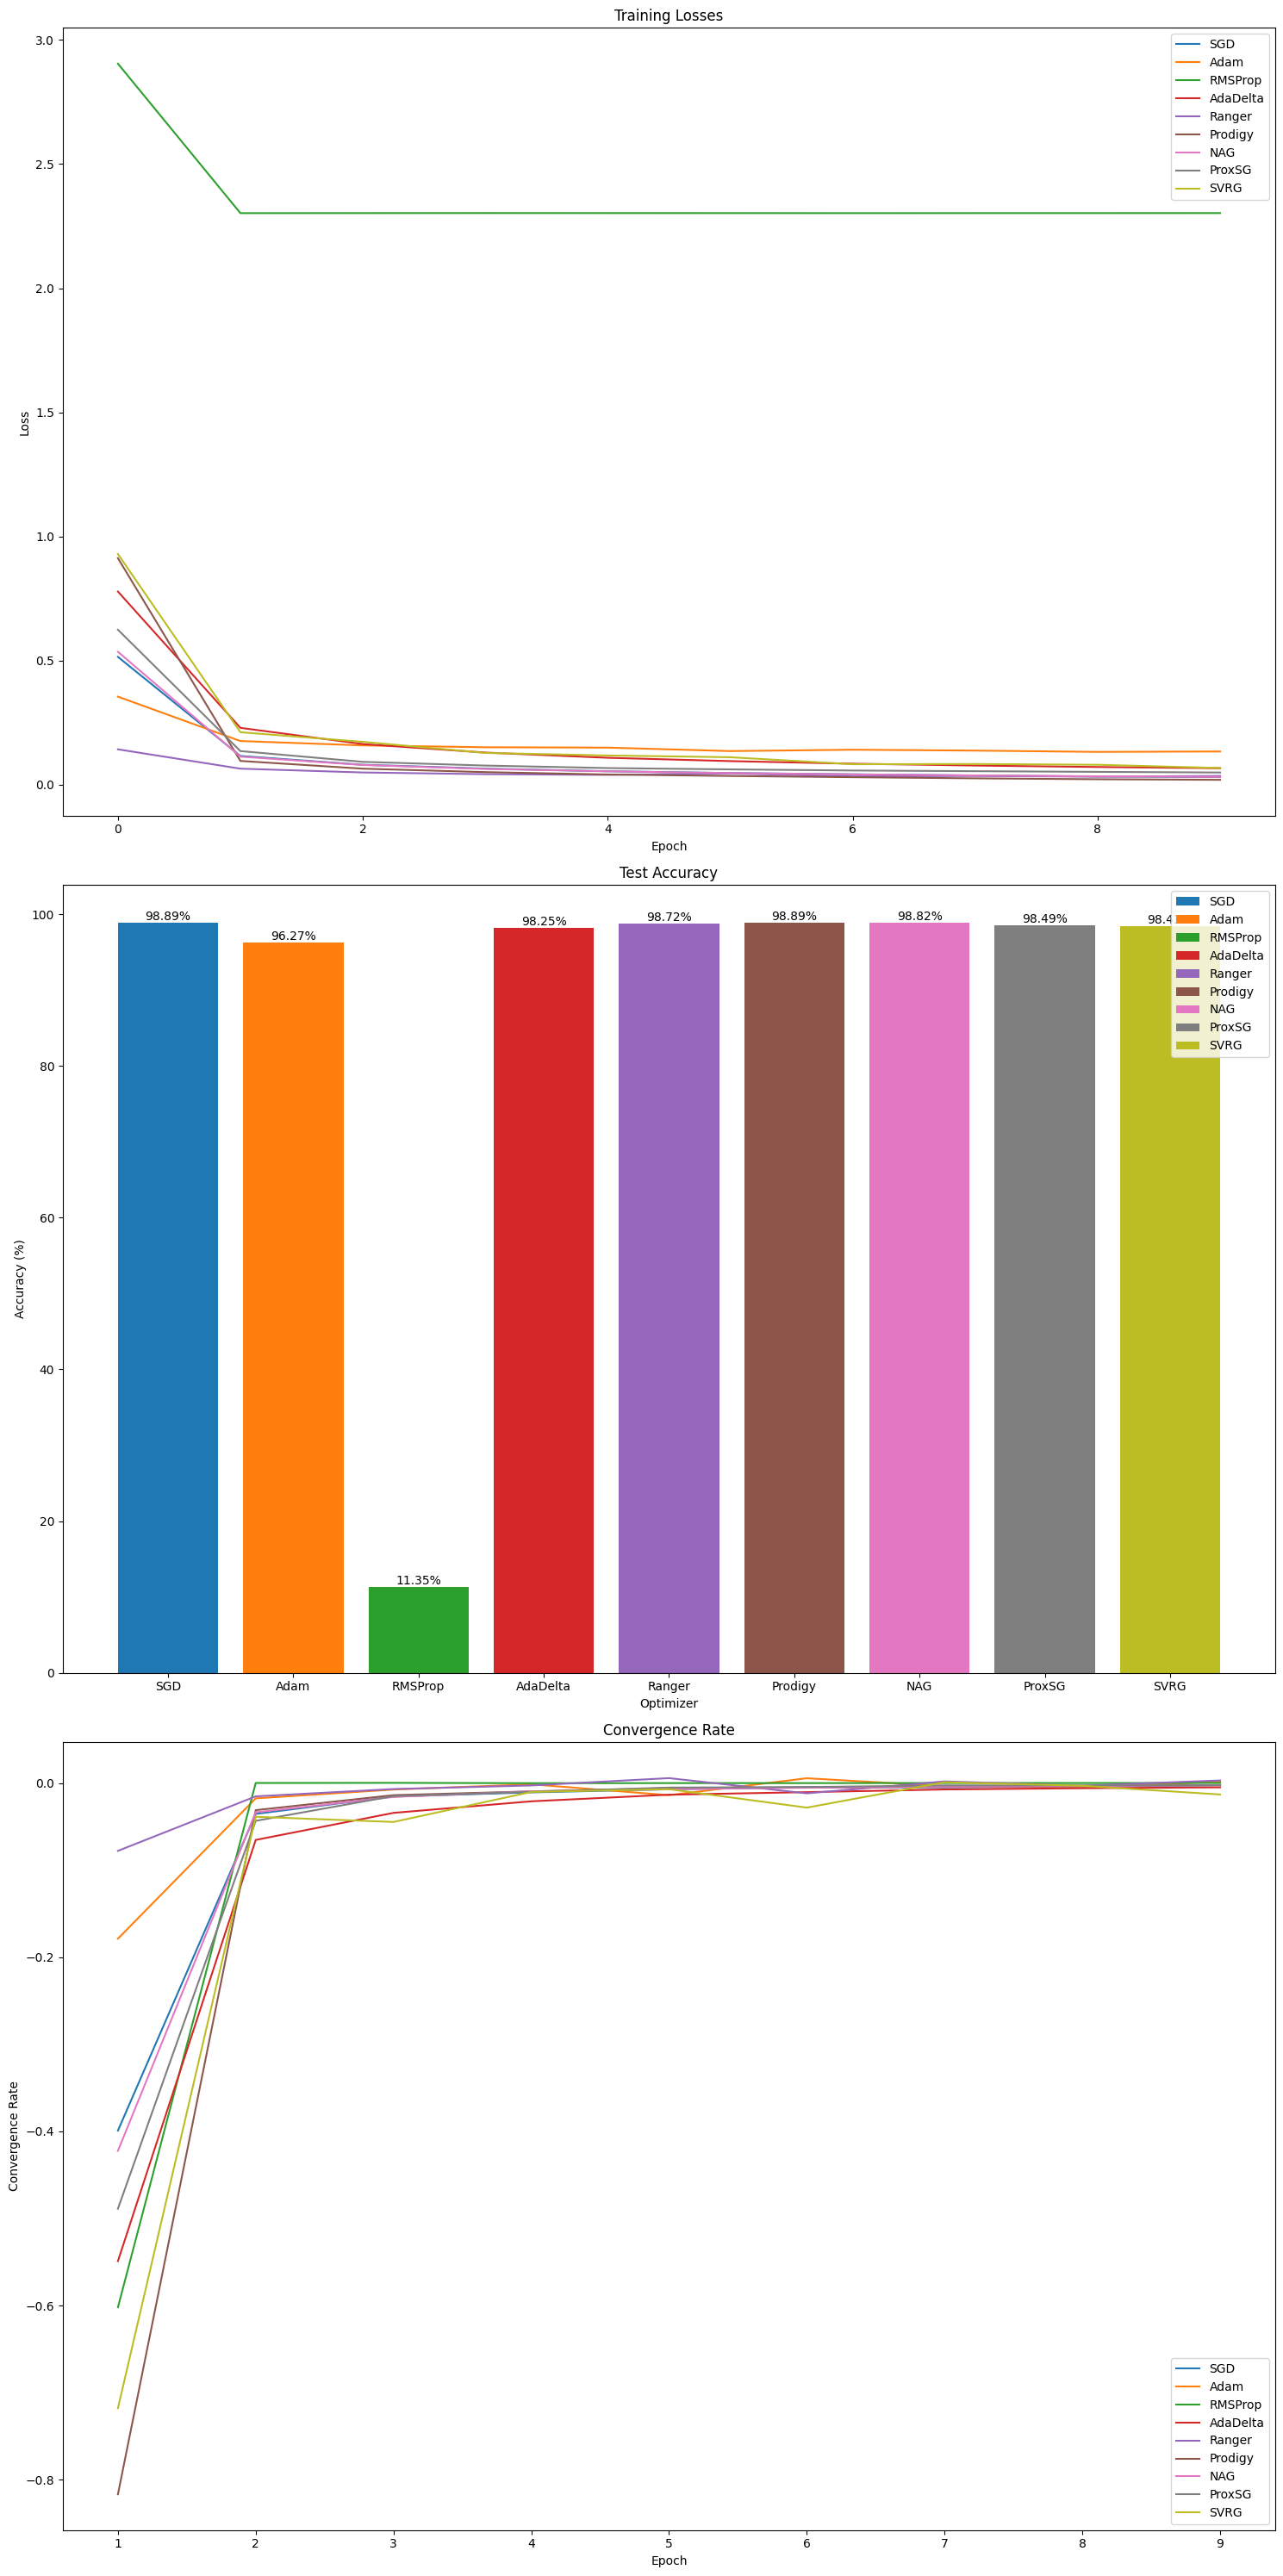

In [25]:
optimizer_names = optimizer_names_1 + optimizer_names_2

fig, axs = plt.subplots(3, 1, figsize=(15, 30))

# Plot losses
for opt_name in optimizer_names:
    losses = train_loss[opt_name]
    axs[0].plot(losses, label=f'{opt_name}')
axs[0].set_title('Training Losses')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot test accuracies
for opt_name in optimizer_names:
    accuracy = test_accuracy[opt_name]
    bar = axs[1].bar(opt_name, accuracy, label=f'{opt_name}')
    axs[1].text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), f'{accuracy:.2f}%', ha='center', va='bottom')
axs[1].set_title('Test Accuracy')
axs[1].set_xlabel('Optimizer')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()

# Plot convergence rates
for opt_name in optimizer_names:
    losses = train_loss[opt_name]
    convergence_rates = [losses[i] - losses[i-1] for i in range(1, len(losses))]
    axs[2].plot(range(1, len(losses)), convergence_rates, label=f'{opt_name}')
axs[2].set_title('Convergence Rate')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Convergence Rate')
axs[2].legend()

plt.tight_layout()
plt.show()